# Introduction

Tuberculosis (TB) is considered to be the second leading cause of death after HIV/AIDS. It infects humans through an airborne bacteria called Mycobacterium Tuberculosis. When active, TB manifests itself through various signs and symptoms, including prolonged cough, night sweats, shortness of breath, weight loss and fever.

Lymphoma is an ensemble of cancerous diseases which are potentially curable. However, in countries with huge tuberculosis (TB) burden, lymphoma patients can be suspected of having TB and receive treatment that they do not need, thus delaying treatment of the cancer. This is due to the similar symptoms both diseases share. 

The research reported here visualises and cleans textual clinical notes for both TB and lymphoma to be used for classification.


# Installing wordcloud library

In [1]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install pyLDAvis
# import platform; print(platform.platform())
# import sys; print("Python", sys.version)
# import numpy; print("NumPy", numpy.__version__)
# import scipy; print("SciPy", scipy.__version__)
# import sklearn; print("Scikit-Learn", sklearn.__version__)

# Loading libraries

In [2]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer

#NLTK
import nltk
nltk.download('punkt')
from nltk.stem import LancasterStemmer
import string
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk import word_tokenize

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries loaded!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kyle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Libraries loaded!


# Load case reports

In [3]:
df1= pd.read_csv('TB.csv',encoding='latin-1')
df2= pd.read_csv('lymphBig.csv',encoding='latin-1')
#df1=df1.drop(['Notes'], axis=1)
#df1=df1.dropna()

In [4]:
print(df1.shape)
print(df2.shape)

(546, 5)
(765, 4)


In [5]:
df1.drop_duplicates(subset='PII', keep='first', inplace=True)
df2.drop_duplicates(subset='PII', keep='first', inplace=True)

In [6]:
print(df1.shape)
print(df2.shape)

(446, 5)
(765, 4)


### Pre-process

In [7]:
# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(['study','used','using','treated','specimen','included','time','times','figure','fig','mm','laboratory','sample','clinic','hospital','et','al','cases','diagnosis','year','month','treatment','treatments','analysis','report','day','years','months','days','performed','examination','test','clinical','disease', 'diseases', 'one','week','symptom','symptoms','found','based','reported','diagnosed','weeks','data','two','level','levels','disorder', 'patient','patients','result','results','cm','mg','ml','dl','l','case','g','revealed','showed'])
# stopwords.update(['patient', 'patients', 'treatment', 'study', 'used', 'using', 'figure', 'fig', 'clinic', 'hospital', 'et','al'])
stopwords.update(['treatment', 'study', 'used', 'using', 'figure', 'fig', 'clinic', 'hospital', 'et','al'])

In [8]:
#Function: Tokenize + filter stop words
def tokenizer_no_stop(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)

    tokens = [token for token in tokens if token not in stopwords]
    return tokens

In [9]:
#Function: Tokenize + filter punctuation + lowercase

def tokenizer_better(text):  
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [10]:
# Function: Tokenize + remove stop words + lemmatize

def stemAndTokenize(text):
    tokens=tokenizer_better(text)
    
    # remove stopwords   
    tokens = [token for token in tokens if token not in stopwords]
    
    # remove one char word   
    tokens = [token for token in tokens if len(token)>1]

    # lower capitalization
    tokens = [word.lower() for word in tokens]

    # lemmatize
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

### Visualise word occurence

In [11]:
def plotFeatures(vect):   
    neg_doc_matrix = vect.transform(df1.Case)
    pos_doc_matrix = vect.transform(df2.Case)
    neg_tf = np.sum(neg_doc_matrix,axis=0)
    pos_tf = np.sum(pos_doc_matrix,axis=0)
    neg = np.squeeze(np.asarray(neg_tf))
    pos = np.squeeze(np.asarray(pos_tf))

    term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
    term_freq_df.columns = ['negative', 'positive']
    term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
    term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

    #Create a series from the sparse matrix
    d = pd.Series(term_freq_df.total, 
                  index = term_freq_df.index).sort_values(ascending=False)
    ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
    ax.title.set_size(18)
    plt.ylabel('count')
    plt.show()
#     ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
#     ax.title.set_size(18)
#     plt.ylabel('count')
#     plt.show()

In [14]:
#Concat all cases
df1["Label"]="1"
df2["Label"]="2"
dfbig=pd.concat([df1,df2])
dfbig.head()

,Unnamed: 0,PII,Title,Case,Label
0,0,S1930043318302334,Pelvic tuberculosis: a forgotten diagnosis  c...,Case report An African14-year-old girl was ad...,1
1,1,S193004331830339X,Rare radiological features of abdominopelvic t...,"Case presentation A 26-year-old woman, para 1...",1
2,4,S1110663818300041,Isolated nasopharyngeal tuberculosis in a 12?y...,Case report A 12?year old boy presented with ...,1
3,5,S2214442018300810,A case report: Addison disease caused by adren...,Case report A 43-year-old man was admitted fo...,1
4,7,S2210261218302311,Rare case of sacrococcygeal tuberculosis mimic...,2 Presentation of case A 93-year-old Japanese...,1


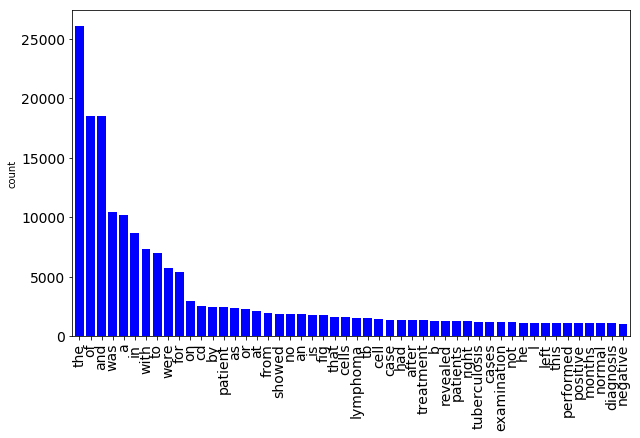

In [15]:
#Visualise words

#vect = CountVectorizer(tokenizer=tokenizer_no_stop)
vect = CountVectorizer(tokenizer=tokenizer_better)
vect.fit(dfbig.Case)
plotFeatures(vect)

### Visualise after pre-processing

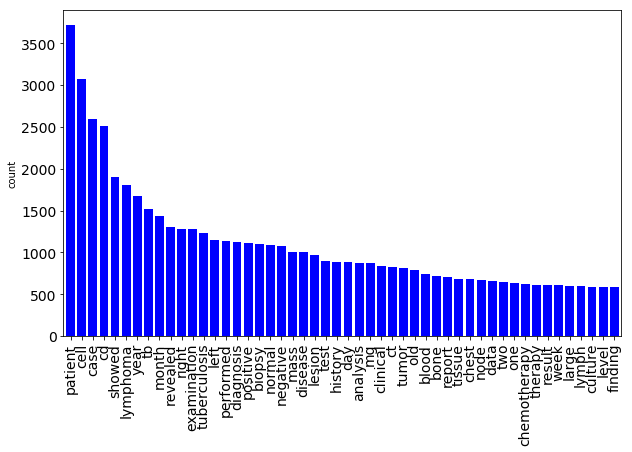

In [16]:
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = stemAndTokenize)
vect.fit(dfbig.Case)
plotFeatures(vect)

## Clustering

In [17]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = stemAndTokenize, stop_words = stopwords,
                                 use_idf=True)
 
def get_tfidf_terms(list_X):
    print ('Running tfid...')
    tfidf_matrix = tfidf_vectorizer.fit_transform(list_X)
    print ('.. done')
    print ('Total vocab terms:' + str(len(tfidf_vectorizer.get_feature_names())))
    return {
        'tfidf_matrix' : tfidf_matrix ,
        'terms' : tfidf_vectorizer.get_feature_names()
    }

Running tfid...


c:\python34\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


.. done
Total vocab terms:19243
For n_clusters = 2 The average silhouette_score is : 0.014642214523550471
For n_clusters = 3 The average silhouette_score is : 0.007992015482525996
For n_clusters = 4 The average silhouette_score is : 0.00930921112373656
For n_clusters = 5 The average silhouette_score is : 0.008449024415596702
For n_clusters = 6 The average silhouette_score is : 0.00810539205603862
For n_clusters = 7 The average silhouette_score is : 0.010145546158965832
For n_clusters = 10 The average silhouette_score is : 0.009150031032119447
For n_clusters = 13 The average silhouette_score is : 0.003655572080843137
For n_clusters = 15 The average silhouette_score is : 0.008136594522940136
For n_clusters = 20 The average silhouette_score is : 0.01047413313135557
For n_clusters = 30 The average silhouette_score is : 0.0074944805484192314


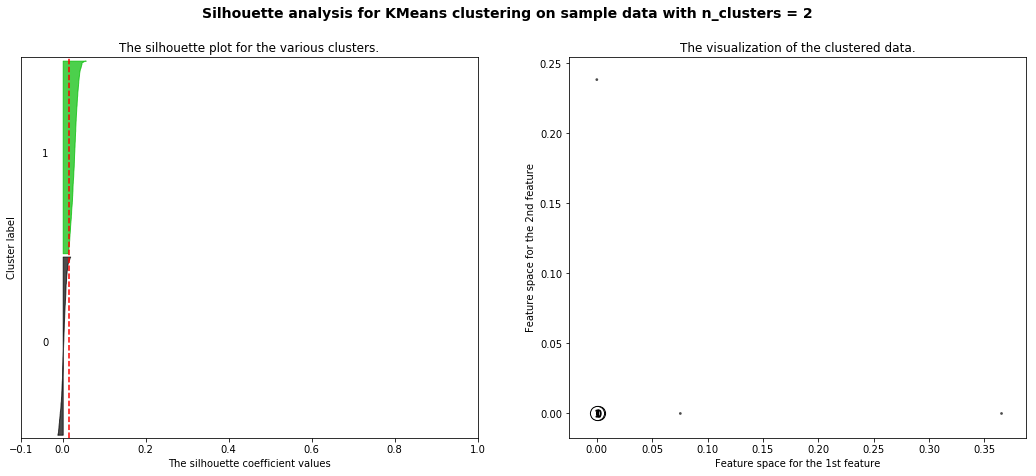

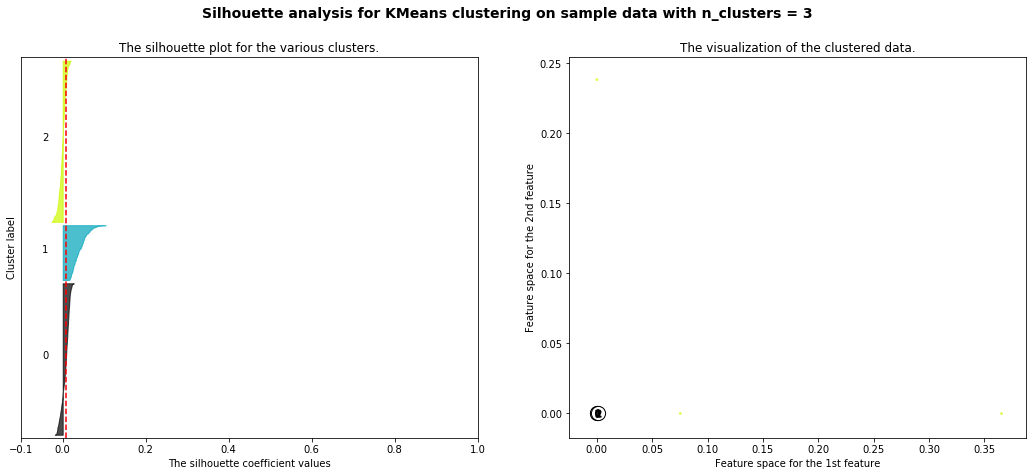

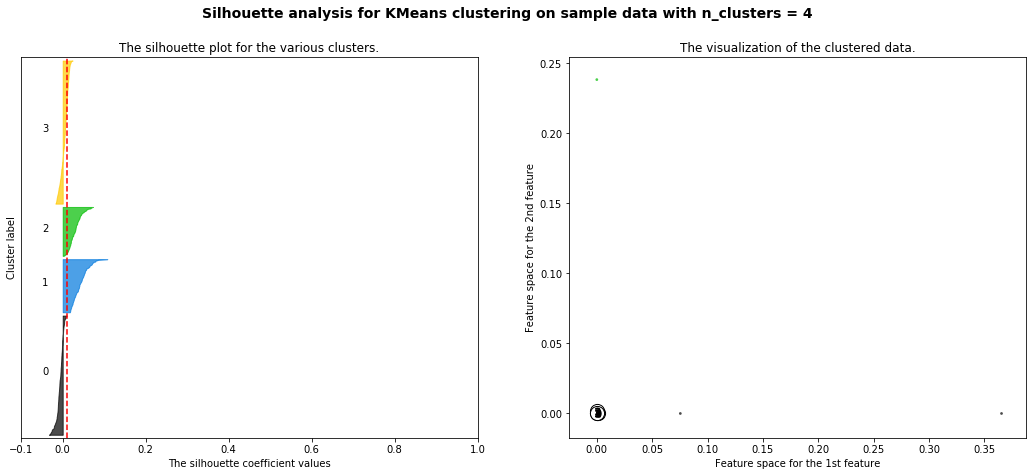

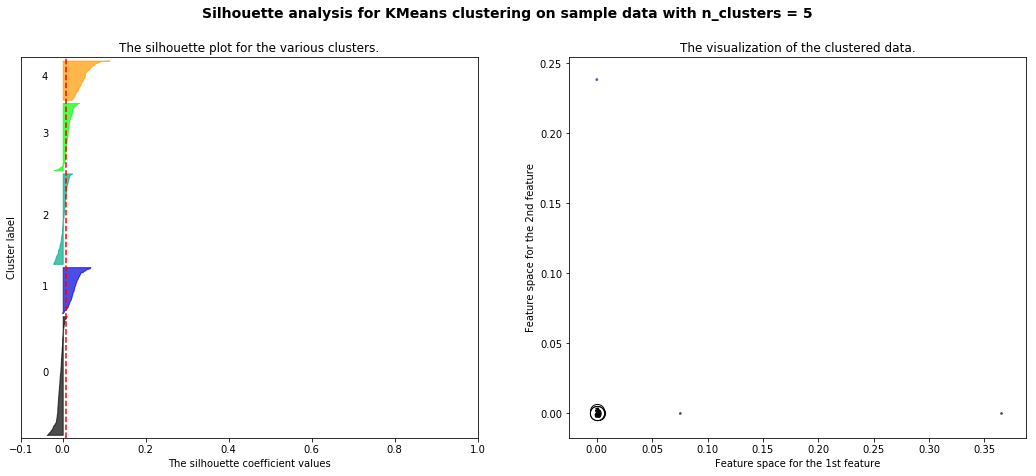

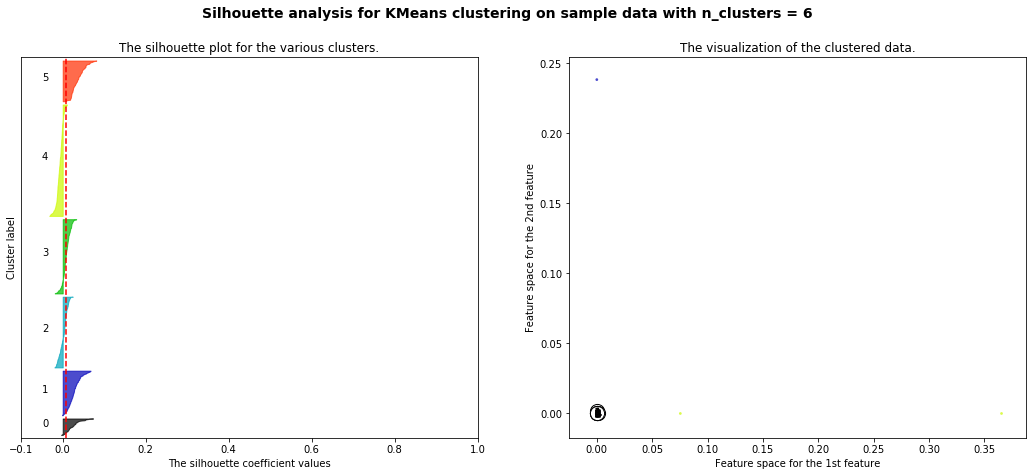

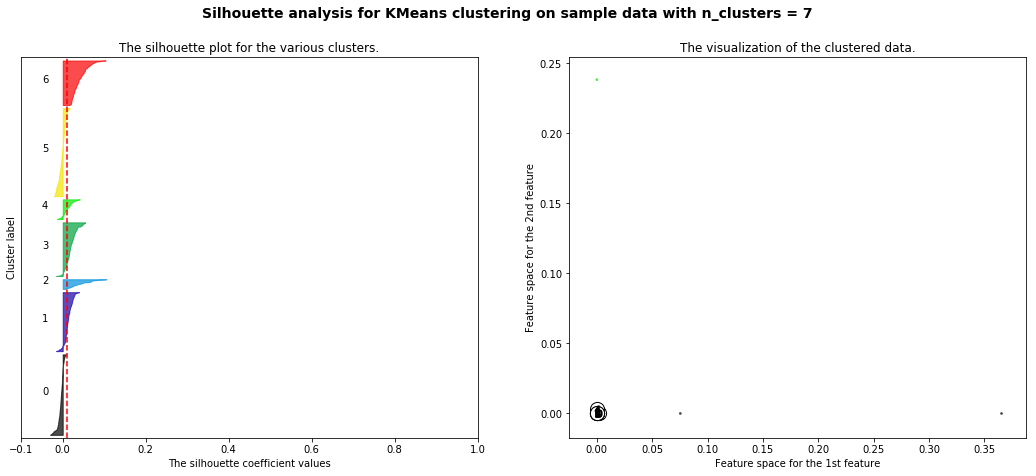

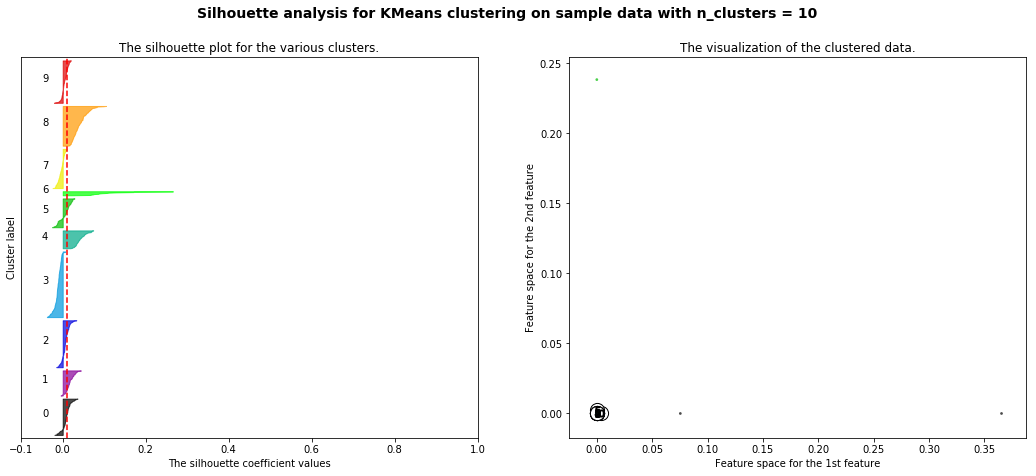

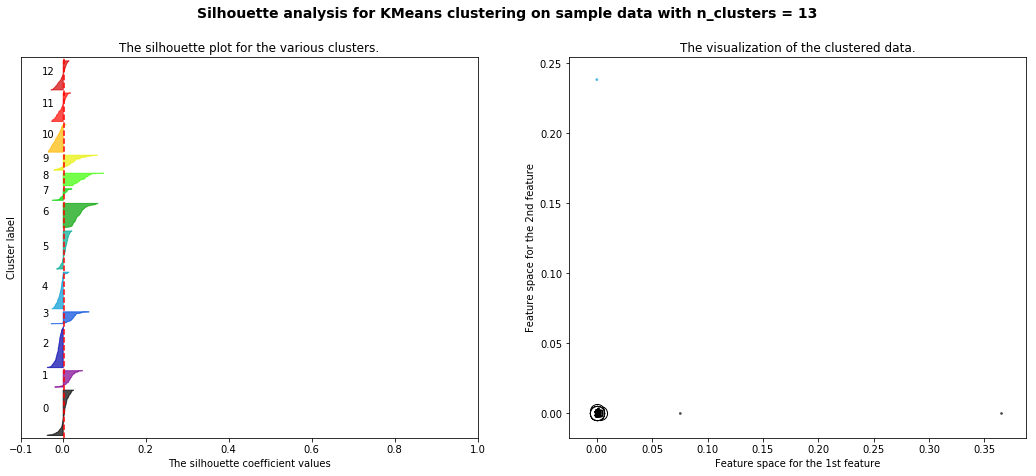

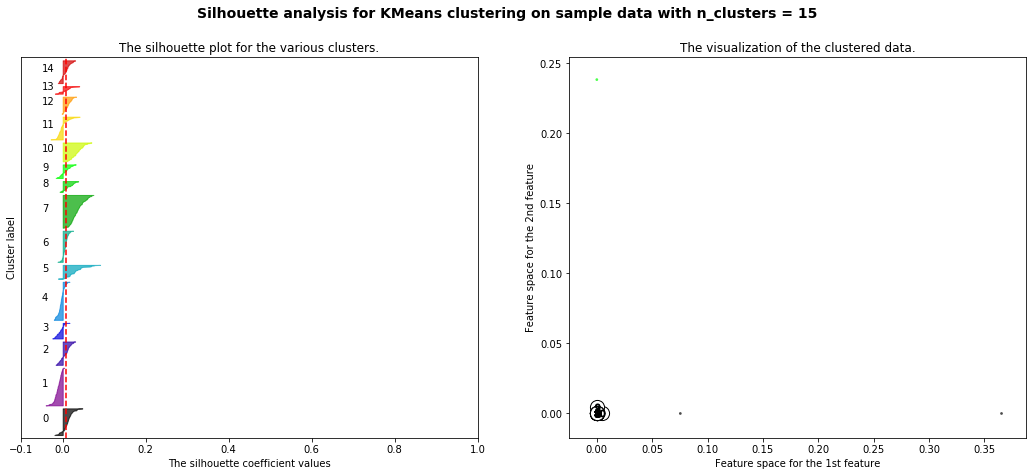

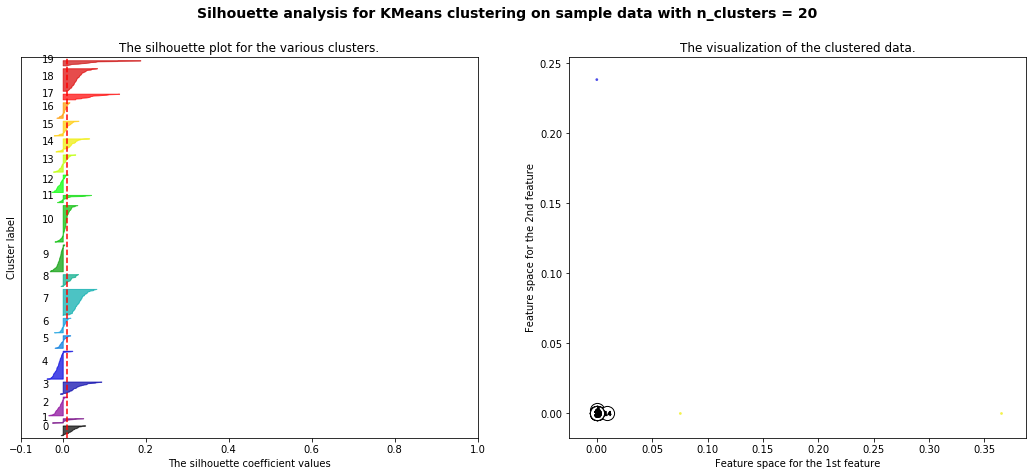

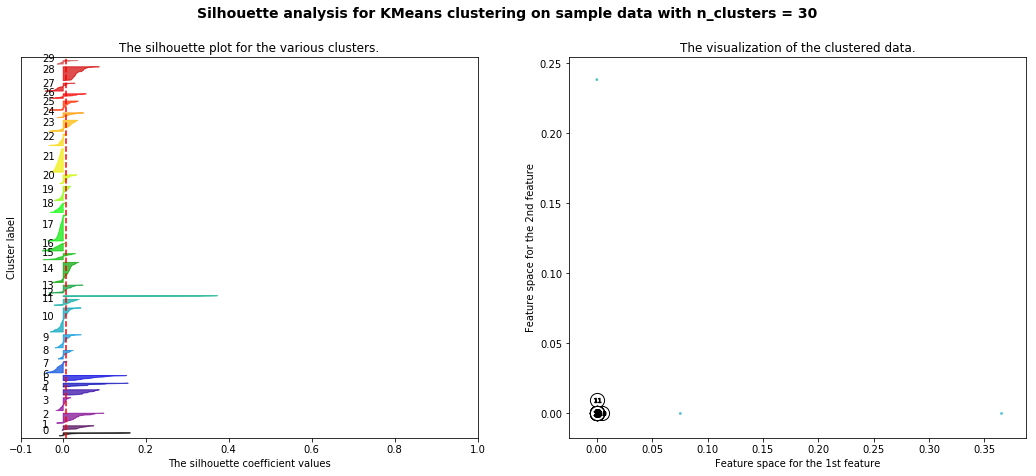

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

tfidf_terms = get_tfidf_terms(dfbig.Case)
X = tfidf_terms['tfidf_matrix']
range_n_clusters = [2, 3, 4, 5, 6,7, 10, 13,15,20, 30]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0].toarray(), X[:, 1].toarray(), marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

c:\python34\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Top terms per cluster:
Cluster 0:
 cd
 cell
 bcl
 showed
 lymphoma
 patient
 biopsy
 revealed
 marrow
 tumor


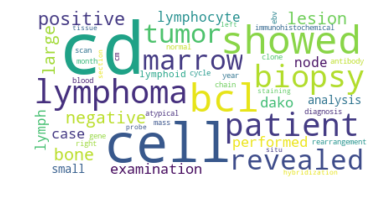

Cluster 1:
 tb
 lymphoma
 case
 patient
 tuberculosis
 cell
 data
 method
 disease
 primary


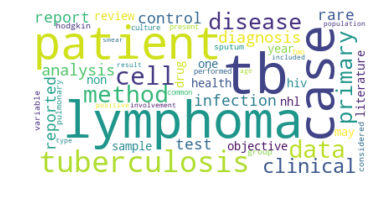

Cluster 2:
 showed
 right
 patient
 left
 revealed
 mass
 examination
 month
 normal
 mg


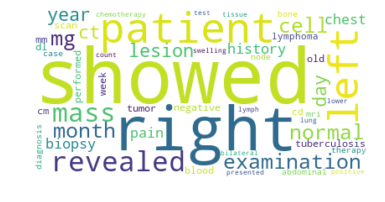

In [19]:
#vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=1000)
X = tfidf_vectorizer.fit_transform(dfbig['Case'].values)
#print(X)
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=84)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
#idfValues=dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))

cluster_map = pd.DataFrame()
cluster_map['data_index'] = dfbig.index.values
cluster_map['cluster'] = model.labels_
labels=model.labels_
text_data_clusters = []
dfclusters = []

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        #Get TD-IDF mean for term
    listOfTerms=[]
    listOfFreq=[]
    for ind in order_centroids[i, :50]:
        listOfFreq.append(model.cluster_centers_[i, ind])
        listOfTerms.append(terms[ind])
        #Go to 50 terms
        #zip in dictionnary: term + TD-IDF
        #Use this dict in cloud
    idfValues=dict(zip(listOfTerms, listOfFreq))
   
    # Generate a word cloud image
    #Frequency must be TD-IDF!!!!!!!!!!!!!!!
    thiscluster=cluster_map[cluster_map.cluster == i]
    thiscluster=dfbig.iloc[thiscluster.data_index]
    
    text = " ".join(review for review in thiscluster.Case)
    text_data_clusters.append(thiscluster.Case.tolist())
    dfclusters.append(thiscluster)

    #wordcloud = WordCloud(background_color="white",max_words=50, stopwords=stopwords).generate(text)
    wordcloud = WordCloud(background_color="white",max_words=50, stopwords=stopwords).generate_from_frequencies(idfValues)
# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



In [20]:
dfclusters[1]

,Unnamed: 0,PII,Title,Case,Label
6,9,S1201971218345211,The use of bedaquiline to treat patients with ...,"Case reports Patient 1 In August 2016, a 46-...",1
7,10,S1413867015002147,Oral manifestation of tuberculosis: a case-report,Case-report A 61-year-old male patient with a...,1
126,165,S0929693X18301684,Potentially preventable tuberculosis cases in ...,2 Methods 2.1 Organization of TB management ...,1
214,368,S2210261214004271,Abdominal tuberculosis mimicking Crohns disea...,2 Presentation of case A 21-year-old man was ...,1
215,369,S0377123717311309,Determinants of adverse treatment outcomes amo...,Materials and methods The present case contro...,1
218,380,S2212553115001132,A case of tuberculosis and adenocarcinoma coex...,Case report A 44-year-old African-American ma...,1
222,391,S1341321X16300332,Paradoxical reaction to antituberculosis thera...,2 Case report A 44-year-old man with a smokin...,1
223,398,S1016319011001303,Extrapulmonary tuberculosis in the wrist prese...,2 Case report A 55-year-old woman had been di...,1
224,403,S1297319X08000365,Congenital spinal tuberculosis associated with...,2 Case report A two-month-old female baby hav...,1
228,427,S1201971215002969,Contacts of retreatment tuberculosis cases wit...,2 Methods This cross-sectional study was cond...,1


In [22]:
#Concat all cases
dfnew=pd.concat([dfclusters[0],dfclusters[1]])
dfnew.head()

,Unnamed: 0,PII,Title,Case,Label
6,9,S1201971218345211,The use of bedaquiline to treat patients with ...,"Case reports Patient 1 In August 2016, a 46-...",1
9,14,S2211753916300598,Chronic Paracoccidioidomycosis with adrenal in...,2 Case A 62-year-old man was transferred from...,1
14,24,S2210261217301931,Ileocaecal and transverse colonic tuberculosis...,2 Case presentation A 46year old female patie...,1
24,36,S0976566216000412,Horner's syndrome in cervico-dorsal tuberculos...,2 Case report A 6-year-old male child was bro...,1
30,43,S1054880716300102,Death at the wheel due to tuberculosis of th...,2 Case report The body of a 35-year-old adult...,1


In [23]:
dfnew.loc[dfnew['Label'] == '1'].Label.count()
# TB cases

431

In [25]:
dfnew.loc[dfnew['Label'] == '2'].Label.count()
#Lymph cases

290

In [26]:
X = tfidf_vectorizer.fit_transform(dfnew['Case'].values)
y = dfnew['Label']

c:\python34\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [34]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import itertools

validation_size = 0.20

seed = 7
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y)
# X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


BEFORE TUNING
LR - accuracy: 0.886121 (0.137051)
LR - precision: 0.954706 (0.068387)
LR - recall: 0.827986 (0.138209)
Confusion matrix, without normalization
[[429   2]
 [ 37 253]]


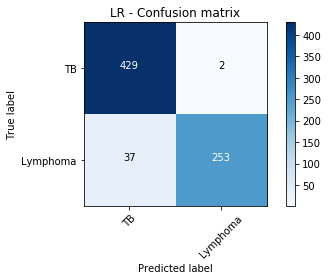

c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA - accuracy: 0.897270 (0.079633)


c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA - precision: 0.846970 (0.226382)


c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA - recall: 0.887043 (0.099435)


c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\python34\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are colli

Confusion matrix, without normalization
[[423   8]
 [ 41 249]]


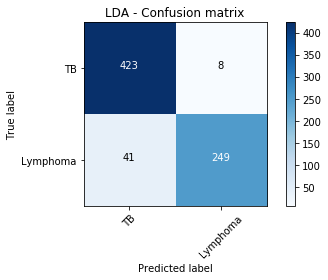

KNN - accuracy: 0.868199 (0.059806)
KNN - precision: 0.772774 (0.198864)
KNN - recall: 0.861239 (0.083218)
Confusion matrix, without normalization
[[406  25]
 [ 40 250]]


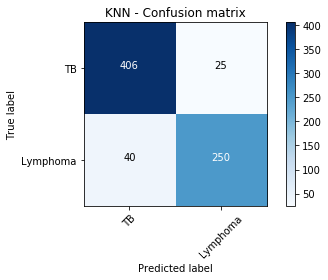

CART - accuracy: 0.934789 (0.019991)
CART - precision: 0.857993 (0.142418)
CART - recall: 0.912361 (0.054688)
Confusion matrix, without normalization
[[418  13]
 [ 21 269]]


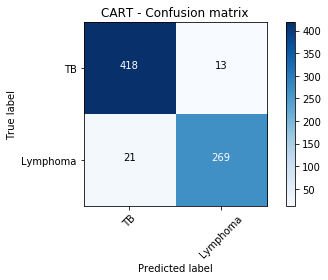

NB - accuracy: 0.829301 (0.098271)
NB - precision: 0.728299 (0.224570)
NB - recall: 0.831210 (0.105468)
Confusion matrix, without normalization
[[389  42]
 [ 44 246]]


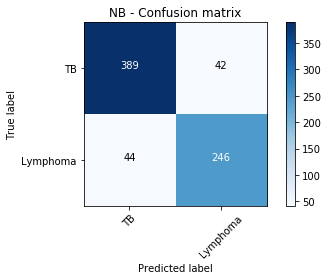

SVM - accuracy: 0.597404 (0.324421)


c:\python34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python34\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 

SVM - precision: 0.000000 (0.000000)
SVM - recall: 0.000000 (0.000000)
Confusion matrix, without normalization
[[431   0]
 [290   0]]


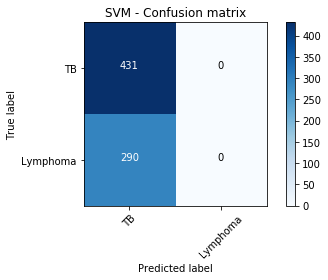

In [37]:
print("BEFORE TUNING")
# X_train = X_train.toarray()
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    for scoring in ['accuracy', 'precision', 'recall']:
        cv_results = model_selection.cross_val_score(model, X.toarray(), lb.fit_transform(y).ravel(), cv=kfold, scoring=scoring)
        results.append((name + ' ' + scoring, cv_results))
        msg = "%s - %s: %f (%f)" % (name, scoring, cv_results.mean(), cv_results.std())
        print(msg)
    y_pred = cross_val_predict(model, X.toarray(), lb.fit_transform(y).ravel(), cv=10)
    cnf_matrix = confusion_matrix(lb.fit_transform(y).ravel(), lb.fit_transform(y_pred).ravel())
    
    np.set_printoptions(precision=2)
    class_names = ['TB', 'Lymphoma']

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title=name + ' - Confusion matrix')

    # Plot normalized confusion matrix
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                           title='Normalized confusion matrix')

    plt.show()